## Human detection

Using SVM prediction base on the featured extract by HOG

In [16]:
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from skimage.io import imread
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import cv2 
import argparse
import cv2
import os
import glob
from PIL import Image # This will be used to read/modify images (can be done via OpenCV too)
from numpy import *

## Define path to image

In [17]:
base_path_test = "../data/human-and-non-human/test_set/test_set" # path for test
base_path_train = "../data/dataset" # path for train

# join the path
pos_im_path = os.path.join(base_path_train, "positive") 
neg_im_path = os.path.join(base_path_train, "negative") #define negative image for SVM training
pos_im_path_test = os.path.join(base_path_test, "humans") # for test data
neg_im_path_test = os.path.join(base_path_test, "non-humans")

# Check if there not exist path
if not os.path.exists(pos_im_path):
    print(f"Error: Path does not exist - {os.path.abspath(pos_im_path)}")
if not os.path.exists(neg_im_path):
    print(f"Error: Path does not exist - {os.path.abspath(neg_im_path)}")
if not os.path.exists(pos_im_path_test):
    print(f"Error: Path does not exist - {os.path.abspath(pos_im_path_test)}")
if not os.path.exists(neg_im_path_test):
    print(f"Error: Path does not exist - {os.path.abspath(neg_im_path_test)}")

# Take the image in that path
pos_im_listing = os.listdir(pos_im_path)
neg_im_listing = os.listdir(neg_im_path)
pos_im_listing_test = os.listdir(pos_im_path_test)
neg_im_listing_test = os.listdir(neg_im_path_test)

num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)
num_pos_test = size(pos_im_listing_test)
num_neg_test = size(neg_im_listing_test)
print(num_pos_samples) # prints the number value of the no.of samples in positive dataset
print(num_neg_samples)
print(num_pos_test)
print(num_neg_test)
data = []
labels = []

2416
4146
245
1309


## Compute the HOG features and label them

In [18]:
# Putting label into positive image

winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
for file in pos_im_listing:
    img_path = os.path.join(pos_im_path, file)
    
    try:
        img = Image.open(img_path).convert("RGB") # Open the file
        # Convert into NumPy array
        img = np.array(img)

        # Convert RGB to BGR (for OpenCV compatibility) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Resize to standard HOG size (64x128) to ensure consistency
        img = cv2.resize(img, (64, 128))

        #Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

        fd = hog.compute(gray).flatten() # Must change into 1D array (because fd return a multi-dimensional vector)
        if fd.shape[0] != 3780:  # Expected size for 64x128 image
            print(f"Skipping {file} due to incorrect HOG feature shape: {fd.shape}")
            continue  # Skip this sample
        data.append(fd)
        labels.append(1)
        
        print(f"Processed training data (positive): {file}")
    except Exception as e:
        print(f"Skipping {file} (Error: {e})")

# Putting label into negative image
for file in neg_im_listing:
    img_path = os.path.join(neg_im_path, file)
    try:
        img = Image.open(img_path).convert("RGB") # Open the file
        # Convert into NumPy array
        img = np.array(img)

        # Convert RGB to BGR (for OpenCV compatibility) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Resize to standard HOG size (64x128) to ensure consistency
        img = cv2.resize(img, (64, 128))

        #Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        fd = hog.compute(gray).flatten() # Must change into 1D array (because fd return a multi-dimensional vector)
        if fd.shape[0] != 3780:  # Expected size for 64x128 image
            print(f"Skipping {file} due to incorrect HOG feature shape: {fd.shape}")
            continue  # Skip this sample
        data.append(fd)
        labels.append(0)
        print(f"Processed training data (negative): {file}")
    except Exception as e:
        print(f"Skipping {file} (Error: {e})")

## Testing label

data_test = []
label_test = []

for file in pos_im_listing_test:
    img_path = os.path.join(pos_im_path_test, file)
    
    try:
        img = Image.open(img_path).convert("RGB") # Open the file
        # Convert into NumPy array
        img = np.array(img)

        # Convert RGB to BGR (for OpenCV compatibility) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Resize to standard HOG size (64x128) to ensure consistency
        img = cv2.resize(img, (64, 128))

        #Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Create a base features (if don't add any parameter, opencv will understand to take a base parameter)

        fd = hog.compute(gray).flatten() # Must change into 1D array (because fd return a multi-dimensional vector)
        if fd.shape[0] != 3780:  # Expected size for 64x128 image
            print(f"Skipping {file} due to incorrect HOG feature shape: {fd.shape}")
            continue  # Skip this sample
        data_test.append(fd)
        label_test.append(1)
        
        print(f"Processed test data (positive): {file}")
    except Exception as e:
        print(f"Skipping {file} (Error: {e})")

# Putting label into negative image
for file in neg_im_listing_test:
    img_path = os.path.join(neg_im_path_test, file)
    try:
        img = Image.open(img_path).convert("RGB") # Open the file
        # Convert into NumPy array
        img = np.array(img)

        # Convert RGB to BGR (for OpenCV compatibility) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Resize to standard HOG size (64x128) to ensure consistency
        img = cv2.resize(img, (64, 128))

        #Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        fd = hog.compute(gray).flatten() # Must change into 1D array (because fd return a multi-dimensional vector)
        if fd.shape[0] != 3780:  # Expected size for 64x128 image
            print(f"Skipping {file} due to incorrect HOG feature shape: {fd.shape}")
            continue  # Skip this sample
        data_test.append(fd)
        label_test.append(0)
        print(f"Processed test data (negative): {file}")
    except Exception as e:
        print(f"Skipping {file} (Error: {e})")


Processed training data (positive): crop001001a.png
Processed training data (positive): crop001001b.png
Processed training data (positive): crop001001c.png
Processed training data (positive): crop001001d.png
Processed training data (positive): crop001001e.png
Processed training data (positive): crop001001f.png
Processed training data (positive): crop001002a.png
Processed training data (positive): crop001002b.png
Processed training data (positive): crop001002c.png
Processed training data (positive): crop001002d.png
Processed training data (positive): crop001003a.png
Processed training data (positive): crop001003b.png
Processed training data (positive): crop001003c.png
Processed training data (positive): crop001003d.png
Processed training data (positive): crop001004a.png
Processed training data (positive): crop001004b.png
Processed training data (positive): crop001004c.png
Processed training data (positive): crop001004d.png
Processed training data (positive): crop001005a.png
Processed tr

In [19]:
print(" Constructing training/testing split...")
data = np.array(data, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)
data_test = np.array(data_test, dtype=np.float32)
label_test = np.array(label_test, dtype=np.int32)

print(data_test.shape)
print(label_test.shape)

(trainData, testData, trainLabels, testLabels) = (data, data_test, labels, label_test)

# Train the linear SVM
print(" Training Linear SVM classifier...")
model = LinearSVC()
model.fit(trainData, trainLabels)
# Evaluate the classifier
print(" Evaluating classifier on test data ...")
pred = model.predict(testData)
# Calculate accuracy
accuracy = accuracy_score(testLabels, pred)
print(f"Accuracy: {accuracy}")

print("Report\n",classification_report(testLabels, pred))

# Save the model
joblib.dump(model, 'SVM_HOG.pkl')
print("SVM Model save Successfully!")


 Constructing training/testing split...
(1554, 3780)
(1554,)
 Training Linear SVM classifier...
 Evaluating classifier on test data ...
Accuracy: 0.8294723294723295
Report
               precision    recall  f1-score   support

           0       0.84      0.98      0.91      1309
           1       0.00      0.00      0.00       245

    accuracy                           0.83      1554
   macro avg       0.42      0.49      0.45      1554
weighted avg       0.71      0.83      0.76      1554

SVM Model save Successfully!


## Load the Trained SVM Model

In [20]:
# Load the model by joblib
model = joblib.load("SVM_HOG.pkl")
print("SVM Model load Successfully!")

SVM Model load Successfully!


## Sliding Window function

In [21]:
# Sliding window technique
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

## Detect people

In [ ]:
down_scale=1.25
window_size=(64,128)
output_folder = 'results/'

# Detect
for file in pos_im_listing_test:
    scale = 0
    img_path = os.path.join(pos_im_path_test, file)

    try:
        img = Image.open(img_path).convert("RGB") # Open the file
        img = np.array(img)
        img = cv2.resize(img, (300,200))

        # Debug: Check the shape of the image
        if img.shape[2] != 3: 
            print("Skip")
            continue

        detections = []
        # Using pyramid to detect the larger or smaller object (scaled the image purpose sliding window will detect different object with original cell)
        for resized in pyramid_gaussian(img, downscale=down_scale, channel_axis = -1):
            # pyramid_gaussian convert the image into [0, 1]
            # So we need to convert back to unit8 
            resized = (resized * 255).astype(np.uint8)  # Convert float64 to uint8, go back [0, 255]
            for (x , y , window) in sliding_window(resized, stepSize = 8, windowSize = window_size): # You can adjust the stepsize
                # validation the window size
                if (window.shape[1] != window_size[0] or window.shape[0] != window_size[1]):
                    continue
                    
                # change the window to gray, easily compute HOG                    
                window = cv2.cvtColor(window, cv2.COLOR_RGB2GRAY)
                #Extract HOG features
                fds = hog.compute(window)
                fds = fds.reshape(1 , -1) # Make become 2d

                #prediction SVM
                pred = model.predict(fds)
                # print(pred)
                if pred == 1:
                    if (model.decision_function(fds) > 0.5): # add threshold
                        back_to_original = down_scale ** scale # When we use pyramid to shrink the image, we will give the detection window back to original size
                        detections.append((x*back_to_original , y*back_to_original
                                           , int(window_size[0]*back_to_original), int(window_size[1]*back_to_original),model.decision_function(fds)))
            scale += 1 # increase the scale 
        clone = img.copy()
        rects = np.array([[x,y,x + w , y + h] for (x,y,w,h,_) in detections])
        sc = [score[0] for (_,_,_,_,score) in detections]
        sc = np.array(sc)
        # Apply Non-Maximum Suppression (NMS) if detections exist
        final_detections = non_max_suppression(rects, probs=sc, overlapThresh=0.35)

        #Draw bouding boxes
        for (x , y , w , h) in final_detections:
            cv2.rectangle(img, (x , y), (x + w, y + h), (0, 255, 0), 2)

        # Convert BGR to RGB for display in matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # write down the result
        output_path = os.path.join(output_folder, file)
        cv2.imwrite(output_path, img_rgb)
        print(f"Processed {file} successful" )
    except Exception as e:
        print(f"Skipping {file} (Error: {e})")

Processed 0.png successful
Processed 1.png successful
Processed 10.png successful
Processed 100.png successful
Processed 101.png successful
Processed 102.png successful
Processed 103.png successful
Processed 104.png successful
Processed 105.png successful
Processed 106.png successful
Processed 107.png successful
Processed 108.png successful
Processed 109.png successful
Processed 11.png successful
Processed 110.png successful
Processed 111.png successful
Processed 112.png successful
Processed 113.png successful
Processed 114.png successful
Processed 115.png successful
Processed 116.png successful
Processed 117.png successful
Processed 118.png successful
Processed 119.png successful
Processed 12.png successful
Processed 120.png successful
Processed 121.png successful
Processed 122.png successful
Processed 123.png successful
Processed 124.png successful
Processed 125.png successful
Processed 126.png successful
Processed 127.png successful
Processed 128.png successful
Processed 129.png suc

## Detect people on video

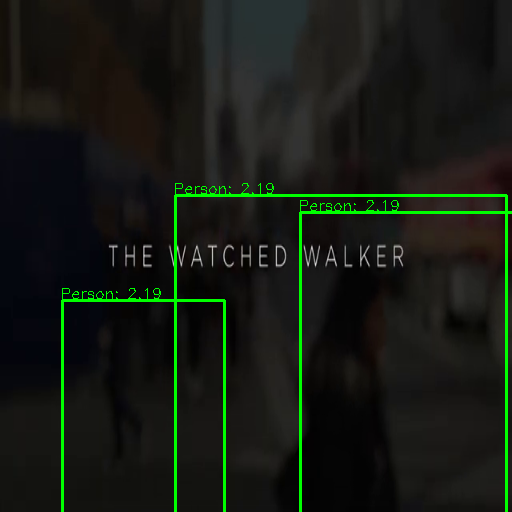

KeyboardInterrupt: 

In [23]:
from IPython.display import display, clear_output
import yt_dlp  
import PIL.Image

# Load YouTube video using pafy
url = 'https://youtu.be/NyLF8nHIquM'
# Get the best video stream
ydl_opts = {}
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(url, download=False)
    video_url = info_dict['url']

cap = cv2.VideoCapture(video_url)

# Set Optimized Performance
cv2.setUseOptimized(True)
cv2.setNumThreads(4)  # Adjust based on CPU

# Process every nth frame (skip frames)
frame_skip = 2
frame_count = 0

# Read and process frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_skip != 0:
        frame_count += 1
        continue

    frame_count += 1  # Increment counter
    
    img = cv2.resize(frame, (512,512))
    detections = []
    scale = 0
    # Using pyramid to detect the larger or smaller object (scaled the image purpose sliding window will detect different object with original cell)
    for resized in pyramid_gaussian(img, downscale=down_scale, channel_axis = -1):
        # pyramid_gaussian convert the image into [0, 1]
        # So we need to convert back to unit8 
        resized = (resized * 255).astype(np.uint8)  # Convert float64 to uint8, go back [0, 255]
        for (x , y , window) in sliding_window(resized, stepSize = 8, windowSize = window_size): # You can adjust the stepsize
            # validation the window size
            if (window.shape[1] != window_size[0] or window.shape[0] != window_size[1]):
                continue
                
            # change the window to gray, easily compute HOG                    
            window = cv2.cvtColor(window, cv2.COLOR_RGB2GRAY)
            #Extract HOG features
            fds = hog.compute(window)
            fds = fds.reshape(1 , -1) # Make become 2d

            #prediction SVM
            pred = model.predict(fds)
            # print(pred)
            if pred == 1:
                if (model.decision_function(fds) > 0.5): # add threshold
                    back_to_original = down_scale ** scale # When we use pyramid to shrink the image, we will give the detection window back to original size
                    detections.append((x*back_to_original , y*back_to_original
                                        , int(window_size[0]*back_to_original), int(window_size[1]*back_to_original),model.decision_function(fds)))
        scale += 1 # increase the scale 
    clone = img.copy()
    rects = np.array([[x,y,x + w , y + h] for (x,y,w,h,_) in detections])
    sc = [score[0] for (_,_,_,_,score) in detections]
    sc = np.array(sc)
    # Apply Non-Maximum Suppression (NMS) if detections exist
    final_detections = non_max_suppression(rects, probs=sc, overlapThresh=0.35)

    #Draw bouding boxes
    for (x , y , w , h) in final_detections:
        cv2.rectangle(img, (x , y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, 'Person: {:.2f}'.format(np.max(sc)), (x - 2, y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Convert BGR to RGB for display in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = PIL.Image.fromarray(img_rgb)

    # Clear previous frame and display new frame
    clear_output(wait=True)
    display(img_pil)
    # Add a small delay and allow stopping
    if cv2.waitKey(1) == 27:  # Press ESC to exit
        break
cap.release()
cv2.destroyAllWindows()
    